**Установка недостающих пакетов**

In [ ]:
!pip install opendatasets
!pip install opencv-python
!pip install scikeras
!pip install missingno
!pip install xgboost
!pip install catboost
!pip install lightgbm

**Импорт данных из Kaggle**

In [12]:
import opendatasets as od
od.download("https://www.kaggle.com/competitions/shift-cv-winter-2023")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akscent
Your Kaggle Key: ········


100%|███████████████████████████████████████████████████████████████████████████████| 150M/150M [00:16<00:00, 9.55MB/s]



Extracting archive .\shift-cv-winter-2023/shift-cv-winter-2023.zip to .\shift-cv-winter-2023


**Импорт необходимых пакетов**

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import cv2
import pywt
import keras
import string
import statsmodels.api as sm 
import matplotlib.gridspec as gridspec
import itertools
import missingno as msno
import folium
from folium.plugins import HeatMap
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from cv2 import IMREAD_COLOR,IMREAD_UNCHANGED
from scipy.ndimage import variance
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from mlxtend.classifier import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

**Чтение тренировчоных данных**

In [2]:
df = pd.read_csv('shift-cv-winter-2023/train.csv')

**Для того, чтобы посмотреть на картинки и предварительно оценить блюр, запишем функции**

In [3]:
def variance_of_laplacian(img2):
    # оценка дисперсии метода Лапласа
    gray = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def BGR2RGB(BGR_img):
    rgb_image = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
    return rgb_image

def blurrinesDetection(directories,threshold, path):
    # определение блюра картинки
    columns = 3
    rows = len(directories)//2
    fig=plt.figure(figsize=(5*columns, 4*rows))
    for i,directory in enumerate(directories):
        fig.add_subplot(rows, columns, i+1)
        img = cv2.imread(directory)
        text = "NOT BLURRY"
        fm = variance_of_laplacian(img)
        if fm < threshold:
            text = "BLURRY"
        rgb_img = BGR2RGB(img)
        cv2.putText(rgb_img, "{}: {} - {:.2f}".format(directory.split(path, 1)[1], text, fm), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (250, 250, 102), 2)
        plt.imshow(rgb_img)
    plt.show()

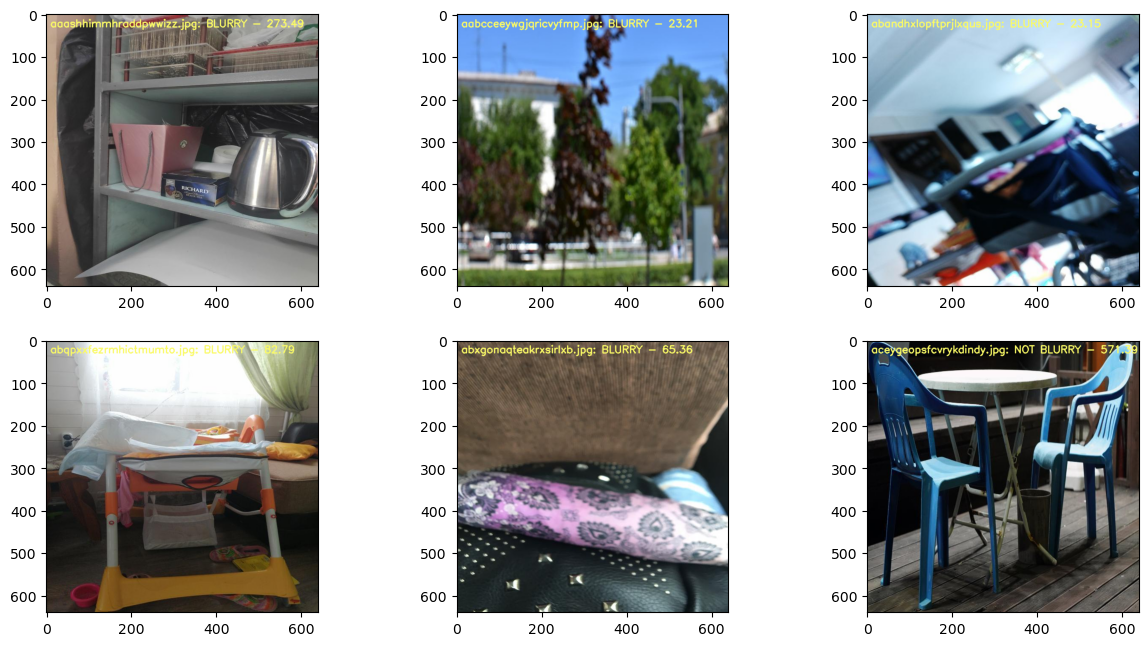

In [4]:
directories = list()
for filename in os.scandir('shift-cv-winter-2023/train/train/'):
    if filename.is_file():
        directories.append(filename.path)

blur = blurrinesDetection(directories[0:6],300, 'shift-cv-winter-2023/train/train/')

**Задача состоит в том, чтобы определить границу значения оценок, когда фото будет классифицироваться. Помимо оценок на основе метода Лапласа, запишем так же функции для оценок методом вейвлет Хаара, SVD и быстрым преобразование Фурье - наиболее точные методы оценки блюра согласно [3]:** 
* Variance(Laplace)	[5]
* Maximum(Laplace) [5]
* Blur degree(SVD)	[1]
* BlurExtent(Haar_wavelet)	[2]
* Mean magnitude(FFT) [4]

In [5]:

def laplaceEdgeVariance(path, const):
    path = const + path
    img = cv2.imread(path)
    img = rgb2gray(img)
    edge_laplace = laplace(img, ksize=3)
    return [variance(edge_laplace),np.amax(edge_laplace)]



def Haar_wavelet(path, const):
    # функция с некоторыми изменениями взята у [https://github.com/pedrofrodenas/blur-Detection-Haar-Wavelet]
    path = const + path
    img = cv2.imread(path)
    Y = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    M, N = Y.shape
    Y = Y[0:int(M/16)*16, 0:int(N/16)*16]
    
    LL1,(LH1,HL1,HH1)= pywt.dwt2(Y, 'haar')
    
    LL2,(LH2,HL2,HH2)= pywt.dwt2(LL1, 'haar') 
    
    LL3,(LH3,HL3,HH3)= pywt.dwt2(LL2, 'haar')
    
    E1 = np.sqrt(np.power(LH1, 2)+np.power(HL1, 2)+np.power(HH1, 2))
    E2 = np.sqrt(np.power(LH2, 2)+np.power(HL2, 2)+np.power(HH2, 2))
    E3 = np.sqrt(np.power(LH3, 2)+np.power(HL3, 2)+np.power(HH3, 2))
    
    M1, N1 = E1.shape

    
    sizeM1 = 8
    sizeN1 = 8
    
    
    sizeM2 = int(sizeM1/2)
    sizeN2 = int(sizeN1/2)
    
    
    sizeM3 = int(sizeM2/2)
    sizeN3 = int(sizeN2/2)
    
    
    N_iter = int((M1/sizeM1)*(N1/sizeN1))
    
    Emax1 = np.zeros((N_iter))
    Emax2 = np.zeros((N_iter))
    Emax3 = np.zeros((N_iter))
    
    count = 0
    
    
    x1 = 0
    y1 = 0
    
    x2 = 0
    y2 = 0
    
    x3 = 0
    y3 = 0
    
    Y_limit = N1-sizeN1
    
    while count < N_iter:
        
        Emax1[count] = np.max(E1[x1:x1+sizeM1,y1:y1+sizeN1])
        Emax2[count] = np.max(E2[x2:x2+sizeM2,y2:y2+sizeN2])
        Emax3[count] = np.max(E3[x3:x3+sizeM3,y3:y3+sizeN3])
        
        if y1 == Y_limit:
            x1 = x1 + sizeM1
            y1 = 0
            
            x2 = x2 + sizeM2
            y2 = 0
            
            x3 = x3 + sizeM3
            y3 = 0
            
            count += 1
        
        else:
                
            y1 = y1 + sizeN1
            y2 = y2 + sizeN2
            y3 = y3 + sizeN3
            count += 1
    
    EdgePoint1 = Emax1 > 35;
    EdgePoint2 = Emax2 > 35;
    EdgePoint3 = Emax3 > 35;
    
    EdgePoint = EdgePoint1 + EdgePoint2 + EdgePoint3
    
    n_edges = EdgePoint.shape[0]
    
    DAstructure = (Emax1[EdgePoint] > Emax2[EdgePoint]) * (Emax2[EdgePoint] > Emax3[EdgePoint]);
    
    RGstructure = np.zeros((n_edges))

    for i in range(n_edges):
    
        if EdgePoint[i] == 1:
        
            if Emax1[i] < Emax2[i] and Emax2[i] < Emax3[i]:
            
                RGstructure[i] = 1
    
    RSstructure = np.zeros((n_edges))

    for i in range(n_edges):
    
        if EdgePoint[i] == 1:
        
            if Emax2[i] > Emax1[i] and Emax2[i] > Emax3[i]:
            
                RSstructure[i] = 1

    BlurC = np.zeros((n_edges));

    for i in range(n_edges):
    
        if RGstructure[i] == 1 or RSstructure[i] == 1:
        
            if Emax1[i] < 35:
            
                BlurC[i] = 1                        
    
    Per = np.sum(DAstructure)/np.sum(EdgePoint)
    if (np.sum(RGstructure) + np.sum(RSstructure)) == 0:
        
        BlurExtent = 100
    else:
        BlurExtent = np.sum(BlurC) / (np.sum(RGstructure) + np.sum(RSstructure))
    
    return [BlurExtent]

def get_blur_degree(path, const):
    path = const + path
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    u, s, v = np.linalg.svd(img)
    top_sv = np.sum(s[0:10])
    total_sv = np.sum(s)
    return top_sv/total_sv

def detect_blur_fft(path, const, size=60):
    path = const + path
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    (h,w) = img.shape
    (cX, cY) = (int(w/2.0), int(h/2.0))
    fft = np.fft.fft2(img)
    fftShift = np.fft.fftshift(fft)
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    return (mean)

In [6]:
def apply_and_concat(dataframe, field, func, const, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell, const=const), index=column_names))), axis=1)

df = apply_and_concat(df,'filename',laplaceEdgeVariance,'shift-cv-winter-2023/train/train/', ['Variance(Laplace)','Maximum(Laplace)'])
df = apply_and_concat(df,'filename',Haar_wavelet,'shift-cv-winter-2023/train/train/', ['BlurExtent(Haar_wavelet)'])
df = apply_and_concat(df,'filename',get_blur_degree,'shift-cv-winter-2023/train/train/', ['Blur degree(SVD)'])
df = apply_and_concat(df,'filename',detect_blur_fft,'shift-cv-winter-2023/train/train/', ['Mean magnitude(FFT)'])
df = df.dropna() # удаляем не подходящие по каким-либо причинам картинки
df.describe()

blur  Variance(Laplace)  Maximum(Laplace)  \
count  2664.000000        2664.000000       2664.000000   
mean      0.486862           0.004299          0.959205   
std       0.499921           0.005989          0.516483   
min       0.000000           0.000007          0.034171   
25%       0.000000           0.000716          0.582042   
50%       0.000000           0.002448          0.930543   
75%       1.000000           0.005806          1.282493   
max       1.000000           0.081088          2.803922   

       BlurExtent(Haar_wavelet)  Blur degree(SVD)  Mean magnitude(FFT)  
count               2664.000000       2664.000000          2664.000000  
mean                   0.725496          0.551956            17.777350  
std                    1.937327          0.120834            11.756360  
min                    0.000000          0.192995           -31.698711  
25%                    0.509806          0.459530             9.627133  
50%                    0.701806          0.538040            18.993177  
75%                    0.904225          0.634038            26.568357  
max                  100.000000          0.969088            57.342242

**Посмотрим на то, как метрики взаимно распределены в зависимости от класса картинки**

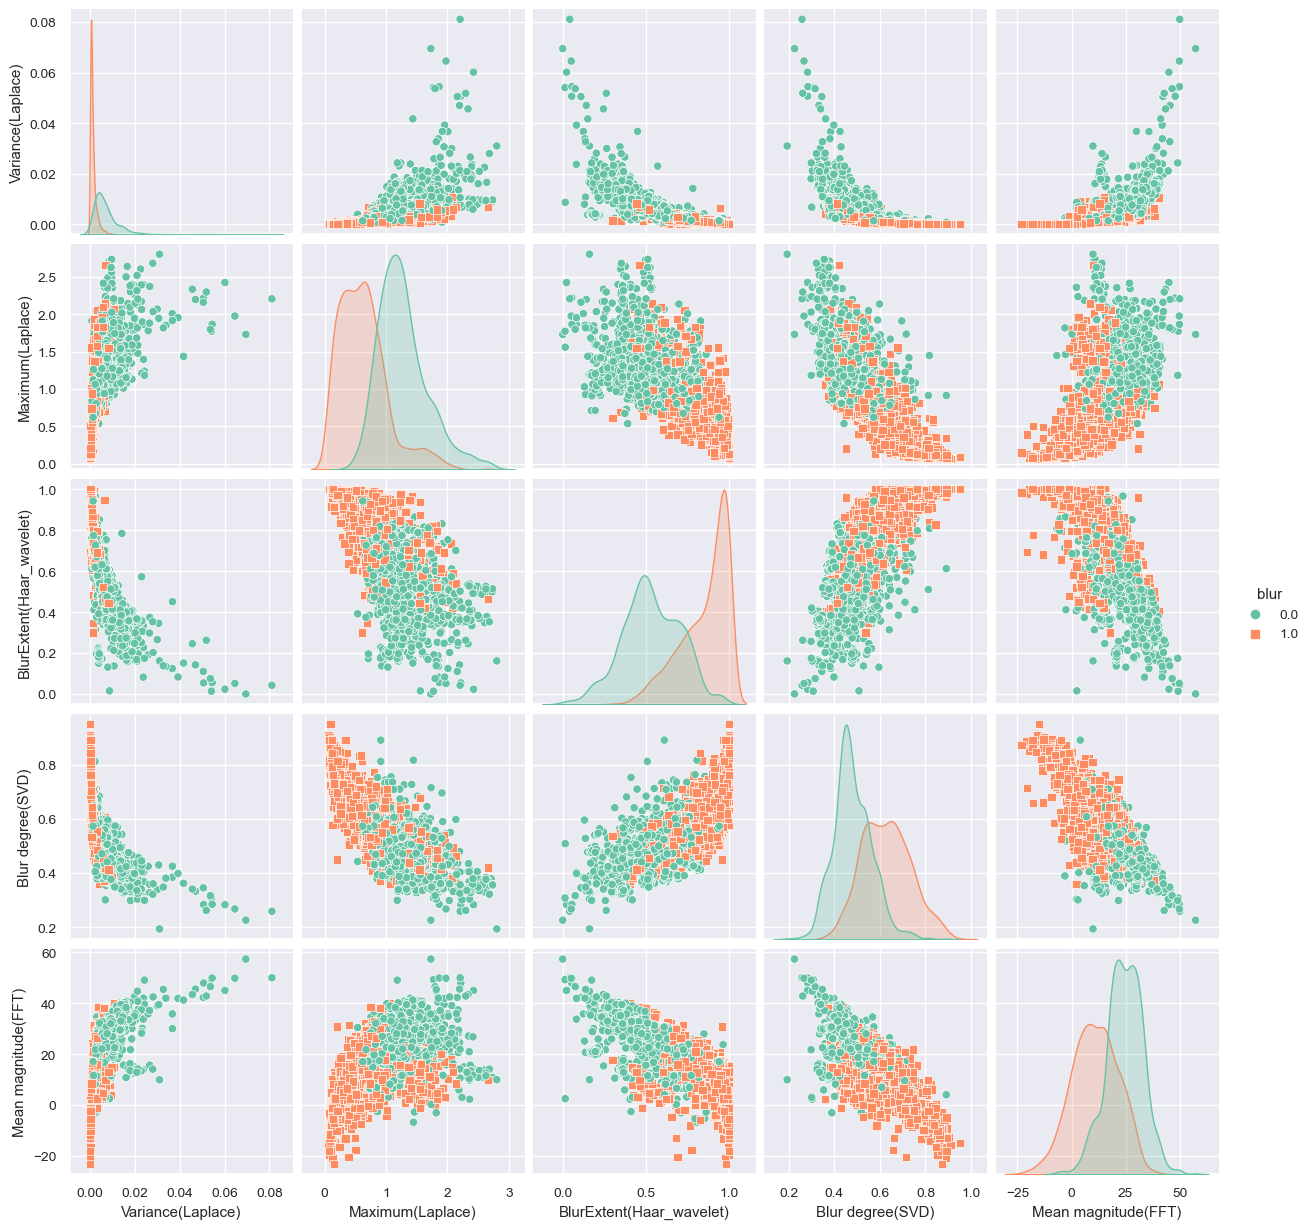

In [274]:
sns.pairplot(df[df['BlurExtent(Haar_wavelet)']<100], kind="scatter", hue="blur", markers=["o", "s"], palette="Set2")
# исключим из визуализации значения BlurExtent(Haar_wavelet) равные 100, поскольку они портят визуализацию
plt.show()

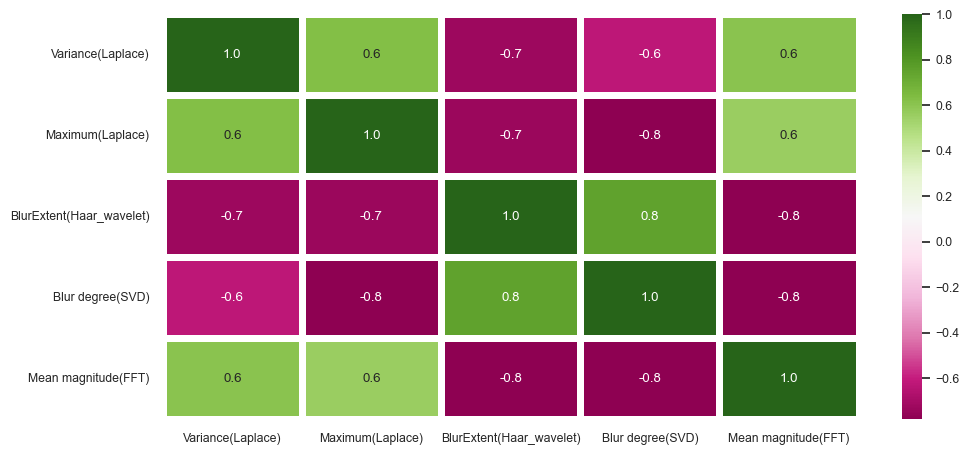

In [277]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df[df['BlurExtent(Haar_wavelet)']<100].drop("blur", axis='columns').corr(), annot=True, linewidths=5, fmt= '.1f', cmap="PiYG")
sns.set(font_scale=0.8)
plt.show()

**Разбиение на тренирвоочные и тестовые данные**

In [51]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

y = df['blur'].astype(int)
X = df.drop("blur", axis='columns')
X = X.drop("filename", axis='columns')

kf = KFold(n_splits=25)
kf.get_n_splits(X)

scores = []


**Создание моделей**

In [64]:
# определим модели классификации, по которым будет происходить оценка

clf1 = LogisticRegression()
clf2 = RandomForestClassifier(max_depth = 50, n_estimators = 500)
clf3 = SVC(random_state=0, probability=True)
clf4 = KNeighborsClassifier()
clf5 = DecisionTreeClassifier()
clf7 = GradientBoostingClassifier(max_depth=5, n_estimators = 500)
clf8 = XGBClassifier(booster = 'gbtree', n_estimators = 300)
clf9 = CatBoostClassifier(iterations=300)
clf10 = ExtraTreesClassifier(max_depth=50, criterion = 'gini', n_estimators = 500)
clf6 = AdaBoostClassifier(base_estimator = clf10)
clf11 = LGBMClassifier(learning_rate = 1)


labels = ['Логистическая регрессия', 'Случайный лес', 'Метод опорных векторов', 'KNN', 'Деревья решений', 
          'Ada Boost','Gradient Boosting', 'XgBoost', 'Cat Boost', 'Extra Trees', 'LGBM']
clfs=[]
from sklearn.metrics import roc_auc_score
roc_score = []
for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10, clf11],
                         labels):
    for col, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        scaler.fit(X_train)
        scaler.fit(X_test)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        clf.fit(X_train, y_train.astype(int))
        #Gauge performance
        score = clf.score(X_test, y_test)
        scores.append(score)
    clf_rate = np.mean(scores)
    clfs.append(clf_rate)


Learning rate set to 0.0464
0:	learn: 0.6393311	total: 2.9ms	remaining: 868ms
1:	learn: 0.5926304	total: 5.57ms	remaining: 830ms
2:	learn: 0.5517388	total: 8.31ms	remaining: 823ms
3:	learn: 0.5169034	total: 10.9ms	remaining: 810ms
4:	learn: 0.4860295	total: 13.6ms	remaining: 804ms
5:	learn: 0.4568183	total: 16.4ms	remaining: 805ms
6:	learn: 0.4337508	total: 19.1ms	remaining: 801ms
7:	learn: 0.4128534	total: 21.7ms	remaining: 793ms
8:	learn: 0.3954724	total: 24.4ms	remaining: 789ms
9:	learn: 0.3777053	total: 27ms	remaining: 784ms
10:	learn: 0.3638476	total: 29.6ms	remaining: 778ms
11:	learn: 0.3510826	total: 32.3ms	remaining: 775ms
12:	learn: 0.3403554	total: 35ms	remaining: 773ms
13:	learn: 0.3281948	total: 37.7ms	remaining: 770ms
14:	learn: 0.3180967	total: 40.3ms	remaining: 766ms
15:	learn: 0.3077896	total: 42.9ms	remaining: 762ms
16:	learn: 0.2981994	total: 45.7ms	remaining: 761ms
17:	learn: 0.2885722	total: 48.3ms	remaining: 756ms
18:	learn: 0.2815908	total: 50.9ms	remaining: 753ms

225:	learn: 0.0856369	total: 604ms	remaining: 198ms
226:	learn: 0.0851777	total: 607ms	remaining: 195ms
227:	learn: 0.0848702	total: 610ms	remaining: 193ms
228:	learn: 0.0844282	total: 613ms	remaining: 190ms
229:	learn: 0.0841921	total: 616ms	remaining: 188ms
230:	learn: 0.0839301	total: 620ms	remaining: 185ms
231:	learn: 0.0837179	total: 623ms	remaining: 182ms
232:	learn: 0.0834586	total: 626ms	remaining: 180ms
233:	learn: 0.0831176	total: 629ms	remaining: 177ms
234:	learn: 0.0829367	total: 632ms	remaining: 175ms
235:	learn: 0.0824017	total: 635ms	remaining: 172ms
236:	learn: 0.0822281	total: 637ms	remaining: 169ms
237:	learn: 0.0818427	total: 640ms	remaining: 167ms
238:	learn: 0.0816700	total: 642ms	remaining: 164ms
239:	learn: 0.0815141	total: 645ms	remaining: 161ms
240:	learn: 0.0813676	total: 648ms	remaining: 159ms
241:	learn: 0.0812021	total: 651ms	remaining: 156ms
242:	learn: 0.0809389	total: 654ms	remaining: 153ms
243:	learn: 0.0806571	total: 657ms	remaining: 151ms
244:	learn: 

136:	learn: 0.1170283	total: 388ms	remaining: 462ms
137:	learn: 0.1166707	total: 391ms	remaining: 459ms
138:	learn: 0.1162029	total: 394ms	remaining: 456ms
139:	learn: 0.1156104	total: 397ms	remaining: 453ms
140:	learn: 0.1153298	total: 399ms	remaining: 450ms
141:	learn: 0.1149355	total: 402ms	remaining: 448ms
142:	learn: 0.1144501	total: 405ms	remaining: 445ms
143:	learn: 0.1141328	total: 408ms	remaining: 442ms
144:	learn: 0.1139021	total: 411ms	remaining: 439ms
145:	learn: 0.1135999	total: 413ms	remaining: 436ms
146:	learn: 0.1132204	total: 416ms	remaining: 433ms
147:	learn: 0.1127797	total: 419ms	remaining: 430ms
148:	learn: 0.1124513	total: 422ms	remaining: 427ms
149:	learn: 0.1121763	total: 424ms	remaining: 424ms
150:	learn: 0.1117483	total: 427ms	remaining: 421ms
151:	learn: 0.1112694	total: 429ms	remaining: 418ms
152:	learn: 0.1110050	total: 432ms	remaining: 415ms
153:	learn: 0.1107475	total: 434ms	remaining: 412ms
154:	learn: 0.1103138	total: 437ms	remaining: 409ms
155:	learn: 

43:	learn: 0.1919630	total: 118ms	remaining: 686ms
44:	learn: 0.1904013	total: 121ms	remaining: 686ms
45:	learn: 0.1887413	total: 124ms	remaining: 684ms
46:	learn: 0.1871984	total: 126ms	remaining: 681ms
47:	learn: 0.1864641	total: 129ms	remaining: 678ms
48:	learn: 0.1846410	total: 132ms	remaining: 675ms
49:	learn: 0.1830195	total: 135ms	remaining: 674ms
50:	learn: 0.1814037	total: 137ms	remaining: 671ms
51:	learn: 0.1800344	total: 140ms	remaining: 667ms
52:	learn: 0.1788918	total: 143ms	remaining: 664ms
53:	learn: 0.1778469	total: 145ms	remaining: 661ms
54:	learn: 0.1768525	total: 148ms	remaining: 657ms
55:	learn: 0.1756199	total: 150ms	remaining: 654ms
56:	learn: 0.1743978	total: 153ms	remaining: 651ms
57:	learn: 0.1737191	total: 155ms	remaining: 647ms
58:	learn: 0.1723121	total: 158ms	remaining: 647ms
59:	learn: 0.1707465	total: 161ms	remaining: 644ms
60:	learn: 0.1698561	total: 164ms	remaining: 641ms
61:	learn: 0.1685927	total: 166ms	remaining: 637ms
62:	learn: 0.1680372	total: 169

256:	learn: 0.0775636	total: 718ms	remaining: 120ms
257:	learn: 0.0772194	total: 721ms	remaining: 117ms
258:	learn: 0.0770850	total: 724ms	remaining: 115ms
259:	learn: 0.0769161	total: 727ms	remaining: 112ms
260:	learn: 0.0767866	total: 729ms	remaining: 109ms
261:	learn: 0.0766432	total: 733ms	remaining: 106ms
262:	learn: 0.0762592	total: 736ms	remaining: 104ms
263:	learn: 0.0759504	total: 739ms	remaining: 101ms
264:	learn: 0.0758681	total: 742ms	remaining: 98ms
265:	learn: 0.0757117	total: 745ms	remaining: 95.2ms
266:	learn: 0.0754856	total: 748ms	remaining: 92.4ms
267:	learn: 0.0754038	total: 750ms	remaining: 89.6ms
268:	learn: 0.0751663	total: 752ms	remaining: 86.7ms
269:	learn: 0.0746636	total: 755ms	remaining: 83.9ms
270:	learn: 0.0743693	total: 758ms	remaining: 81.1ms
271:	learn: 0.0742613	total: 760ms	remaining: 78.2ms
272:	learn: 0.0738688	total: 763ms	remaining: 75.5ms
273:	learn: 0.0737663	total: 766ms	remaining: 72.6ms
274:	learn: 0.0735513	total: 768ms	remaining: 69.9ms
275

160:	learn: 0.1075878	total: 455ms	remaining: 393ms
161:	learn: 0.1071381	total: 459ms	remaining: 391ms
162:	learn: 0.1068849	total: 462ms	remaining: 388ms
163:	learn: 0.1064739	total: 465ms	remaining: 386ms
164:	learn: 0.1063395	total: 468ms	remaining: 383ms
165:	learn: 0.1058327	total: 472ms	remaining: 381ms
166:	learn: 0.1053952	total: 475ms	remaining: 378ms
167:	learn: 0.1050188	total: 478ms	remaining: 376ms
168:	learn: 0.1047044	total: 481ms	remaining: 373ms
169:	learn: 0.1043039	total: 484ms	remaining: 370ms
170:	learn: 0.1040093	total: 487ms	remaining: 368ms
171:	learn: 0.1036355	total: 490ms	remaining: 365ms
172:	learn: 0.1030980	total: 493ms	remaining: 362ms
173:	learn: 0.1026225	total: 496ms	remaining: 359ms
174:	learn: 0.1022734	total: 499ms	remaining: 357ms
175:	learn: 0.1019266	total: 503ms	remaining: 354ms
176:	learn: 0.1014734	total: 506ms	remaining: 352ms
177:	learn: 0.1010560	total: 509ms	remaining: 349ms
178:	learn: 0.1007998	total: 512ms	remaining: 346ms
179:	learn: 

76:	learn: 0.1514478	total: 198ms	remaining: 572ms
77:	learn: 0.1510112	total: 201ms	remaining: 573ms
78:	learn: 0.1499430	total: 204ms	remaining: 571ms
79:	learn: 0.1488632	total: 207ms	remaining: 569ms
80:	learn: 0.1485067	total: 210ms	remaining: 568ms
81:	learn: 0.1474646	total: 213ms	remaining: 567ms
82:	learn: 0.1468568	total: 216ms	remaining: 565ms
83:	learn: 0.1460227	total: 219ms	remaining: 564ms
84:	learn: 0.1448536	total: 222ms	remaining: 562ms
85:	learn: 0.1442610	total: 225ms	remaining: 561ms
86:	learn: 0.1434905	total: 228ms	remaining: 559ms
87:	learn: 0.1427466	total: 231ms	remaining: 557ms
88:	learn: 0.1421697	total: 234ms	remaining: 555ms
89:	learn: 0.1414563	total: 237ms	remaining: 553ms
90:	learn: 0.1410113	total: 240ms	remaining: 551ms
91:	learn: 0.1401996	total: 243ms	remaining: 549ms
92:	learn: 0.1393729	total: 246ms	remaining: 547ms
93:	learn: 0.1388245	total: 249ms	remaining: 545ms
94:	learn: 0.1380468	total: 252ms	remaining: 543ms
95:	learn: 0.1376601	total: 255

282:	learn: 0.0700455	total: 787ms	remaining: 47.3ms
283:	learn: 0.0697367	total: 790ms	remaining: 44.5ms
284:	learn: 0.0695434	total: 793ms	remaining: 41.8ms
285:	learn: 0.0693112	total: 796ms	remaining: 39ms
286:	learn: 0.0690412	total: 800ms	remaining: 36.2ms
287:	learn: 0.0688655	total: 803ms	remaining: 33.5ms
288:	learn: 0.0686108	total: 807ms	remaining: 30.7ms
289:	learn: 0.0682645	total: 810ms	remaining: 27.9ms
290:	learn: 0.0679859	total: 813ms	remaining: 25.1ms
291:	learn: 0.0678234	total: 816ms	remaining: 22.4ms
292:	learn: 0.0674208	total: 819ms	remaining: 19.6ms
293:	learn: 0.0671370	total: 822ms	remaining: 16.8ms
294:	learn: 0.0670248	total: 825ms	remaining: 14ms
295:	learn: 0.0668262	total: 829ms	remaining: 11.2ms
296:	learn: 0.0667528	total: 832ms	remaining: 8.4ms
297:	learn: 0.0665320	total: 835ms	remaining: 5.6ms
298:	learn: 0.0664353	total: 838ms	remaining: 2.8ms
299:	learn: 0.0663062	total: 841ms	remaining: 0us
Learning rate set to 0.0464
0:	learn: 0.6404843	total: 3

182:	learn: 0.1017846	total: 521ms	remaining: 333ms
183:	learn: 0.1014660	total: 524ms	remaining: 330ms
184:	learn: 0.1013371	total: 527ms	remaining: 328ms
185:	learn: 0.1010266	total: 531ms	remaining: 325ms
186:	learn: 0.1007099	total: 534ms	remaining: 323ms
187:	learn: 0.1002585	total: 537ms	remaining: 320ms
188:	learn: 0.0997826	total: 541ms	remaining: 318ms
189:	learn: 0.0993229	total: 544ms	remaining: 315ms
190:	learn: 0.0991803	total: 547ms	remaining: 312ms
191:	learn: 0.0987285	total: 550ms	remaining: 309ms
192:	learn: 0.0984541	total: 553ms	remaining: 306ms
193:	learn: 0.0981221	total: 556ms	remaining: 304ms
194:	learn: 0.0977714	total: 559ms	remaining: 301ms
195:	learn: 0.0975108	total: 562ms	remaining: 298ms
196:	learn: 0.0971813	total: 565ms	remaining: 295ms
197:	learn: 0.0968099	total: 568ms	remaining: 292ms
198:	learn: 0.0964842	total: 571ms	remaining: 290ms
199:	learn: 0.0960909	total: 573ms	remaining: 287ms
200:	learn: 0.0956738	total: 577ms	remaining: 284ms
201:	learn: 

89:	learn: 0.1424334	total: 246ms	remaining: 574ms
90:	learn: 0.1421520	total: 250ms	remaining: 573ms
91:	learn: 0.1412046	total: 253ms	remaining: 571ms
92:	learn: 0.1407846	total: 256ms	remaining: 569ms
93:	learn: 0.1402556	total: 259ms	remaining: 567ms
94:	learn: 0.1394720	total: 262ms	remaining: 565ms
95:	learn: 0.1391042	total: 265ms	remaining: 563ms
96:	learn: 0.1386998	total: 269ms	remaining: 562ms
97:	learn: 0.1381108	total: 272ms	remaining: 560ms
98:	learn: 0.1377182	total: 275ms	remaining: 558ms
99:	learn: 0.1368406	total: 278ms	remaining: 555ms
100:	learn: 0.1360774	total: 281ms	remaining: 553ms
101:	learn: 0.1356124	total: 284ms	remaining: 551ms
102:	learn: 0.1352855	total: 287ms	remaining: 548ms
103:	learn: 0.1345839	total: 289ms	remaining: 545ms
104:	learn: 0.1337277	total: 292ms	remaining: 542ms
105:	learn: 0.1331183	total: 294ms	remaining: 539ms
106:	learn: 0.1327034	total: 297ms	remaining: 536ms
107:	learn: 0.1318400	total: 300ms	remaining: 533ms
108:	learn: 0.1315022	t

5:	learn: 0.4574313	total: 15.9ms	remaining: 782ms
6:	learn: 0.4358642	total: 19.1ms	remaining: 798ms
7:	learn: 0.4131786	total: 21.9ms	remaining: 798ms
8:	learn: 0.3950046	total: 24.7ms	remaining: 798ms
9:	learn: 0.3770882	total: 27.5ms	remaining: 799ms
10:	learn: 0.3626005	total: 30.3ms	remaining: 797ms
11:	learn: 0.3511577	total: 33.3ms	remaining: 799ms
12:	learn: 0.3394983	total: 36.3ms	remaining: 801ms
13:	learn: 0.3272462	total: 38.6ms	remaining: 789ms
14:	learn: 0.3140884	total: 41.2ms	remaining: 783ms
15:	learn: 0.3041219	total: 43.7ms	remaining: 775ms
16:	learn: 0.2948464	total: 46.2ms	remaining: 768ms
17:	learn: 0.2869808	total: 48.6ms	remaining: 762ms
18:	learn: 0.2792918	total: 51.4ms	remaining: 760ms
19:	learn: 0.2738126	total: 54.2ms	remaining: 759ms
20:	learn: 0.2672595	total: 56.9ms	remaining: 756ms
21:	learn: 0.2608387	total: 59.4ms	remaining: 750ms
22:	learn: 0.2562184	total: 61.9ms	remaining: 746ms
23:	learn: 0.2503506	total: 64.4ms	remaining: 741ms
24:	learn: 0.2449

225:	learn: 0.0856160	total: 628ms	remaining: 206ms
226:	learn: 0.0853704	total: 631ms	remaining: 203ms
227:	learn: 0.0850020	total: 633ms	remaining: 200ms
228:	learn: 0.0848077	total: 636ms	remaining: 197ms
229:	learn: 0.0846415	total: 639ms	remaining: 194ms
230:	learn: 0.0843579	total: 642ms	remaining: 192ms
231:	learn: 0.0841391	total: 645ms	remaining: 189ms
232:	learn: 0.0839524	total: 649ms	remaining: 187ms
233:	learn: 0.0837069	total: 651ms	remaining: 184ms
234:	learn: 0.0835561	total: 654ms	remaining: 181ms
235:	learn: 0.0830076	total: 657ms	remaining: 178ms
236:	learn: 0.0826035	total: 659ms	remaining: 175ms
237:	learn: 0.0820914	total: 662ms	remaining: 172ms
238:	learn: 0.0816842	total: 665ms	remaining: 170ms
239:	learn: 0.0815355	total: 668ms	remaining: 167ms
240:	learn: 0.0813274	total: 671ms	remaining: 164ms
241:	learn: 0.0812012	total: 673ms	remaining: 161ms
242:	learn: 0.0809940	total: 676ms	remaining: 158ms
243:	learn: 0.0805602	total: 678ms	remaining: 156ms
244:	learn: 

154:	learn: 0.1086494	total: 394ms	remaining: 369ms
155:	learn: 0.1080850	total: 398ms	remaining: 367ms
156:	learn: 0.1078636	total: 400ms	remaining: 365ms
157:	learn: 0.1076843	total: 403ms	remaining: 362ms
158:	learn: 0.1073482	total: 406ms	remaining: 360ms
159:	learn: 0.1072517	total: 408ms	remaining: 357ms
160:	learn: 0.1067015	total: 411ms	remaining: 355ms
161:	learn: 0.1062617	total: 414ms	remaining: 353ms
162:	learn: 0.1057786	total: 416ms	remaining: 350ms
163:	learn: 0.1054092	total: 419ms	remaining: 347ms
164:	learn: 0.1052181	total: 421ms	remaining: 345ms
165:	learn: 0.1049362	total: 424ms	remaining: 342ms
166:	learn: 0.1046159	total: 427ms	remaining: 340ms
167:	learn: 0.1043702	total: 430ms	remaining: 338ms
168:	learn: 0.1040598	total: 432ms	remaining: 335ms
169:	learn: 0.1037642	total: 435ms	remaining: 332ms
170:	learn: 0.1034368	total: 437ms	remaining: 330ms
171:	learn: 0.1030955	total: 440ms	remaining: 327ms
172:	learn: 0.1027462	total: 442ms	remaining: 325ms
173:	learn: 

72:	learn: 0.1526225	total: 190ms	remaining: 592ms
73:	learn: 0.1514415	total: 193ms	remaining: 590ms
74:	learn: 0.1509823	total: 196ms	remaining: 587ms
75:	learn: 0.1504657	total: 198ms	remaining: 585ms
76:	learn: 0.1497189	total: 201ms	remaining: 582ms
77:	learn: 0.1493931	total: 204ms	remaining: 580ms
78:	learn: 0.1484237	total: 207ms	remaining: 578ms
79:	learn: 0.1472572	total: 209ms	remaining: 576ms
80:	learn: 0.1466808	total: 212ms	remaining: 573ms
81:	learn: 0.1461358	total: 214ms	remaining: 570ms
82:	learn: 0.1455099	total: 217ms	remaining: 567ms
83:	learn: 0.1442767	total: 219ms	remaining: 564ms
84:	learn: 0.1434201	total: 222ms	remaining: 561ms
85:	learn: 0.1423414	total: 225ms	remaining: 559ms
86:	learn: 0.1414524	total: 228ms	remaining: 557ms
87:	learn: 0.1407241	total: 230ms	remaining: 554ms
88:	learn: 0.1403149	total: 233ms	remaining: 552ms
89:	learn: 0.1397566	total: 236ms	remaining: 550ms
90:	learn: 0.1392194	total: 238ms	remaining: 547ms
91:	learn: 0.1382174	total: 241

295:	learn: 0.0648991	total: 800ms	remaining: 10.8ms
296:	learn: 0.0647371	total: 804ms	remaining: 8.12ms
297:	learn: 0.0644476	total: 807ms	remaining: 5.41ms
298:	learn: 0.0640332	total: 810ms	remaining: 2.71ms
299:	learn: 0.0638900	total: 813ms	remaining: 0us
Learning rate set to 0.0464
0:	learn: 0.6404233	total: 3.25ms	remaining: 971ms
1:	learn: 0.5944519	total: 6.64ms	remaining: 989ms
2:	learn: 0.5529908	total: 9.96ms	remaining: 986ms
3:	learn: 0.5181772	total: 12.9ms	remaining: 953ms
4:	learn: 0.4874362	total: 15.7ms	remaining: 928ms
5:	learn: 0.4579254	total: 18.6ms	remaining: 914ms
6:	learn: 0.4379567	total: 21.5ms	remaining: 900ms
7:	learn: 0.4153444	total: 24.7ms	remaining: 903ms
8:	learn: 0.3978622	total: 28.3ms	remaining: 915ms
9:	learn: 0.3801813	total: 31.5ms	remaining: 913ms
10:	learn: 0.3659152	total: 34.9ms	remaining: 916ms
11:	learn: 0.3531531	total: 37.8ms	remaining: 907ms
12:	learn: 0.3408627	total: 40.7ms	remaining: 899ms
13:	learn: 0.3285741	total: 44.4ms	remaining

178:	learn: 0.0991798	total: 564ms	remaining: 381ms
179:	learn: 0.0988383	total: 568ms	remaining: 378ms
180:	learn: 0.0984649	total: 571ms	remaining: 376ms
181:	learn: 0.0981267	total: 575ms	remaining: 372ms
182:	learn: 0.0980267	total: 578ms	remaining: 369ms
183:	learn: 0.0975075	total: 581ms	remaining: 367ms
184:	learn: 0.0970561	total: 585ms	remaining: 364ms
185:	learn: 0.0965164	total: 588ms	remaining: 360ms
186:	learn: 0.0961891	total: 591ms	remaining: 357ms
187:	learn: 0.0958032	total: 594ms	remaining: 354ms
188:	learn: 0.0952053	total: 597ms	remaining: 351ms
189:	learn: 0.0946215	total: 600ms	remaining: 347ms
190:	learn: 0.0942772	total: 604ms	remaining: 345ms
191:	learn: 0.0938811	total: 607ms	remaining: 341ms
192:	learn: 0.0934670	total: 610ms	remaining: 338ms
193:	learn: 0.0932859	total: 613ms	remaining: 335ms
194:	learn: 0.0930233	total: 616ms	remaining: 332ms
195:	learn: 0.0927323	total: 619ms	remaining: 329ms
196:	learn: 0.0923156	total: 622ms	remaining: 325ms
197:	learn: 

74:	learn: 0.1548202	total: 218ms	remaining: 653ms
75:	learn: 0.1540750	total: 222ms	remaining: 653ms
76:	learn: 0.1530212	total: 225ms	remaining: 651ms
77:	learn: 0.1525799	total: 228ms	remaining: 648ms
78:	learn: 0.1516059	total: 231ms	remaining: 646ms
79:	learn: 0.1504912	total: 234ms	remaining: 644ms
80:	learn: 0.1498883	total: 238ms	remaining: 643ms
81:	learn: 0.1489009	total: 241ms	remaining: 641ms
82:	learn: 0.1480718	total: 244ms	remaining: 638ms
83:	learn: 0.1472009	total: 248ms	remaining: 637ms
84:	learn: 0.1465165	total: 251ms	remaining: 634ms
85:	learn: 0.1454624	total: 254ms	remaining: 632ms
86:	learn: 0.1446192	total: 257ms	remaining: 629ms
87:	learn: 0.1440348	total: 260ms	remaining: 626ms
88:	learn: 0.1436462	total: 263ms	remaining: 623ms
89:	learn: 0.1429881	total: 266ms	remaining: 620ms
90:	learn: 0.1425170	total: 269ms	remaining: 617ms
91:	learn: 0.1416448	total: 272ms	remaining: 614ms
92:	learn: 0.1412253	total: 275ms	remaining: 611ms
93:	learn: 0.1405615	total: 278

276:	learn: 0.0731813	total: 835ms	remaining: 69.3ms
277:	learn: 0.0730134	total: 838ms	remaining: 66.3ms
278:	learn: 0.0725342	total: 842ms	remaining: 63.4ms
279:	learn: 0.0724839	total: 845ms	remaining: 60.4ms
280:	learn: 0.0723236	total: 848ms	remaining: 57.4ms
281:	learn: 0.0720648	total: 852ms	remaining: 54.4ms
282:	learn: 0.0717580	total: 856ms	remaining: 51.4ms
283:	learn: 0.0715926	total: 859ms	remaining: 48.4ms
284:	learn: 0.0713545	total: 862ms	remaining: 45.4ms
285:	learn: 0.0713017	total: 865ms	remaining: 42.4ms
286:	learn: 0.0711860	total: 868ms	remaining: 39.3ms
287:	learn: 0.0710211	total: 871ms	remaining: 36.3ms
288:	learn: 0.0708485	total: 874ms	remaining: 33.3ms
289:	learn: 0.0706370	total: 878ms	remaining: 30.3ms
290:	learn: 0.0703265	total: 881ms	remaining: 27.2ms
291:	learn: 0.0700435	total: 884ms	remaining: 24.2ms
292:	learn: 0.0697634	total: 887ms	remaining: 21.2ms
293:	learn: 0.0695170	total: 889ms	remaining: 18.2ms
294:	learn: 0.0692500	total: 892ms	remaining: 

135:	learn: 0.1147662	total: 439ms	remaining: 530ms
136:	learn: 0.1144376	total: 442ms	remaining: 526ms
137:	learn: 0.1140769	total: 445ms	remaining: 523ms
138:	learn: 0.1137716	total: 448ms	remaining: 519ms
139:	learn: 0.1132317	total: 451ms	remaining: 515ms
140:	learn: 0.1129739	total: 454ms	remaining: 512ms
141:	learn: 0.1126403	total: 457ms	remaining: 509ms
142:	learn: 0.1120481	total: 460ms	remaining: 506ms
143:	learn: 0.1118129	total: 463ms	remaining: 502ms
144:	learn: 0.1115794	total: 466ms	remaining: 498ms
145:	learn: 0.1113148	total: 469ms	remaining: 495ms
146:	learn: 0.1109553	total: 472ms	remaining: 491ms
147:	learn: 0.1104914	total: 475ms	remaining: 488ms
148:	learn: 0.1102224	total: 478ms	remaining: 484ms
149:	learn: 0.1097801	total: 481ms	remaining: 481ms
150:	learn: 0.1093841	total: 484ms	remaining: 477ms
151:	learn: 0.1089505	total: 487ms	remaining: 474ms
152:	learn: 0.1084952	total: 489ms	remaining: 470ms
153:	learn: 0.1078809	total: 492ms	remaining: 467ms
154:	learn: 

26:	learn: 0.2329068	total: 81.2ms	remaining: 821ms
27:	learn: 0.2289566	total: 84.8ms	remaining: 824ms
28:	learn: 0.2253313	total: 88.2ms	remaining: 824ms
29:	learn: 0.2216891	total: 91.4ms	remaining: 823ms
30:	learn: 0.2176120	total: 94.8ms	remaining: 822ms
31:	learn: 0.2146234	total: 98.2ms	remaining: 822ms
32:	learn: 0.2117142	total: 102ms	remaining: 823ms
33:	learn: 0.2091866	total: 105ms	remaining: 821ms
34:	learn: 0.2060640	total: 108ms	remaining: 816ms
35:	learn: 0.2032625	total: 111ms	remaining: 813ms
36:	learn: 0.2011893	total: 114ms	remaining: 810ms
37:	learn: 0.1984774	total: 117ms	remaining: 805ms
38:	learn: 0.1960242	total: 120ms	remaining: 801ms
39:	learn: 0.1940613	total: 123ms	remaining: 797ms
40:	learn: 0.1924912	total: 126ms	remaining: 795ms
41:	learn: 0.1909226	total: 129ms	remaining: 791ms
42:	learn: 0.1887826	total: 132ms	remaining: 786ms
43:	learn: 0.1870363	total: 135ms	remaining: 783ms
44:	learn: 0.1850413	total: 138ms	remaining: 784ms
45:	learn: 0.1834214	tota

227:	learn: 0.0830880	total: 699ms	remaining: 221ms
228:	learn: 0.0830401	total: 702ms	remaining: 218ms
229:	learn: 0.0829243	total: 705ms	remaining: 215ms
230:	learn: 0.0827253	total: 708ms	remaining: 212ms
231:	learn: 0.0825664	total: 712ms	remaining: 209ms
232:	learn: 0.0823751	total: 715ms	remaining: 206ms
233:	learn: 0.0818253	total: 719ms	remaining: 203ms
234:	learn: 0.0817670	total: 723ms	remaining: 200ms
235:	learn: 0.0814571	total: 726ms	remaining: 197ms
236:	learn: 0.0813532	total: 730ms	remaining: 194ms
237:	learn: 0.0809628	total: 733ms	remaining: 191ms
238:	learn: 0.0804887	total: 736ms	remaining: 188ms
239:	learn: 0.0804383	total: 739ms	remaining: 185ms
240:	learn: 0.0800224	total: 742ms	remaining: 182ms
241:	learn: 0.0798480	total: 745ms	remaining: 179ms
242:	learn: 0.0794622	total: 748ms	remaining: 176ms
243:	learn: 0.0791422	total: 752ms	remaining: 172ms
244:	learn: 0.0787115	total: 755ms	remaining: 169ms
245:	learn: 0.0783232	total: 758ms	remaining: 166ms
246:	learn: 

111:	learn: 0.1264558	total: 344ms	remaining: 578ms
112:	learn: 0.1260278	total: 348ms	remaining: 575ms
113:	learn: 0.1252372	total: 351ms	remaining: 573ms
114:	learn: 0.1244350	total: 355ms	remaining: 570ms
115:	learn: 0.1241355	total: 358ms	remaining: 568ms
116:	learn: 0.1234556	total: 361ms	remaining: 565ms
117:	learn: 0.1231153	total: 365ms	remaining: 562ms
118:	learn: 0.1229340	total: 368ms	remaining: 559ms
119:	learn: 0.1225090	total: 371ms	remaining: 556ms
120:	learn: 0.1221180	total: 374ms	remaining: 553ms
121:	learn: 0.1216471	total: 377ms	remaining: 550ms
122:	learn: 0.1212199	total: 380ms	remaining: 547ms
123:	learn: 0.1207565	total: 383ms	remaining: 543ms
124:	learn: 0.1202496	total: 386ms	remaining: 540ms
125:	learn: 0.1195856	total: 389ms	remaining: 537ms
126:	learn: 0.1190215	total: 392ms	remaining: 534ms
127:	learn: 0.1187510	total: 395ms	remaining: 531ms
128:	learn: 0.1181315	total: 398ms	remaining: 527ms
129:	learn: 0.1176581	total: 401ms	remaining: 524ms
130:	learn: 

5:	learn: 0.4595347	total: 19ms	remaining: 932ms
6:	learn: 0.4360020	total: 22.6ms	remaining: 944ms
7:	learn: 0.4128454	total: 25.8ms	remaining: 941ms
8:	learn: 0.3942530	total: 29.1ms	remaining: 942ms
9:	learn: 0.3766970	total: 32.7ms	remaining: 948ms
10:	learn: 0.3628216	total: 36.1ms	remaining: 948ms
11:	learn: 0.3470626	total: 42.6ms	remaining: 1.02s
12:	learn: 0.3355827	total: 49.1ms	remaining: 1.08s
13:	learn: 0.3238922	total: 52.5ms	remaining: 1.07s
14:	learn: 0.3148703	total: 56.6ms	remaining: 1.08s
15:	learn: 0.3051458	total: 60.1ms	remaining: 1.07s
16:	learn: 0.2958757	total: 63.4ms	remaining: 1.06s
17:	learn: 0.2878786	total: 66.6ms	remaining: 1.04s
18:	learn: 0.2810371	total: 69.6ms	remaining: 1.03s
19:	learn: 0.2761566	total: 72.6ms	remaining: 1.02s
20:	learn: 0.2695004	total: 75.7ms	remaining: 1s
21:	learn: 0.2617681	total: 78.7ms	remaining: 995ms
22:	learn: 0.2571785	total: 81.7ms	remaining: 984ms
23:	learn: 0.2511410	total: 84.8ms	remaining: 975ms
24:	learn: 0.2456865	t

193:	learn: 0.0957026	total: 625ms	remaining: 342ms
194:	learn: 0.0952288	total: 629ms	remaining: 339ms
195:	learn: 0.0949312	total: 632ms	remaining: 336ms
196:	learn: 0.0946261	total: 636ms	remaining: 332ms
197:	learn: 0.0943172	total: 639ms	remaining: 329ms
198:	learn: 0.0937371	total: 643ms	remaining: 326ms
199:	learn: 0.0933031	total: 647ms	remaining: 323ms
200:	learn: 0.0928905	total: 650ms	remaining: 320ms
201:	learn: 0.0925610	total: 654ms	remaining: 317ms
202:	learn: 0.0920487	total: 657ms	remaining: 314ms
203:	learn: 0.0915307	total: 661ms	remaining: 311ms
204:	learn: 0.0913307	total: 664ms	remaining: 308ms
205:	learn: 0.0909327	total: 668ms	remaining: 305ms
206:	learn: 0.0903380	total: 671ms	remaining: 301ms
207:	learn: 0.0900672	total: 674ms	remaining: 298ms
208:	learn: 0.0898231	total: 677ms	remaining: 295ms
209:	learn: 0.0894792	total: 681ms	remaining: 292ms
210:	learn: 0.0890543	total: 684ms	remaining: 289ms
211:	learn: 0.0887697	total: 688ms	remaining: 285ms
212:	learn: 

74:	learn: 0.1532250	total: 241ms	remaining: 724ms
75:	learn: 0.1525427	total: 246ms	remaining: 724ms
76:	learn: 0.1517298	total: 249ms	remaining: 721ms
77:	learn: 0.1510716	total: 253ms	remaining: 720ms
78:	learn: 0.1499047	total: 257ms	remaining: 718ms
79:	learn: 0.1491758	total: 261ms	remaining: 717ms
80:	learn: 0.1483449	total: 265ms	remaining: 716ms
81:	learn: 0.1478087	total: 268ms	remaining: 712ms
82:	learn: 0.1471876	total: 271ms	remaining: 708ms
83:	learn: 0.1460576	total: 274ms	remaining: 706ms
84:	learn: 0.1448763	total: 277ms	remaining: 702ms
85:	learn: 0.1442189	total: 281ms	remaining: 698ms
86:	learn: 0.1433878	total: 284ms	remaining: 694ms
87:	learn: 0.1424727	total: 287ms	remaining: 691ms
88:	learn: 0.1421275	total: 290ms	remaining: 688ms
89:	learn: 0.1414833	total: 293ms	remaining: 684ms
90:	learn: 0.1411031	total: 296ms	remaining: 680ms
91:	learn: 0.1402951	total: 299ms	remaining: 677ms
92:	learn: 0.1393992	total: 303ms	remaining: 674ms
93:	learn: 0.1388662	total: 306

268:	learn: 0.0735451	total: 843ms	remaining: 97.2ms
269:	learn: 0.0731066	total: 847ms	remaining: 94.1ms
270:	learn: 0.0729494	total: 851ms	remaining: 91ms
271:	learn: 0.0726316	total: 854ms	remaining: 87.9ms
272:	learn: 0.0724439	total: 857ms	remaining: 84.8ms
273:	learn: 0.0722090	total: 861ms	remaining: 81.7ms
274:	learn: 0.0720191	total: 864ms	remaining: 78.6ms
275:	learn: 0.0719013	total: 867ms	remaining: 75.4ms
276:	learn: 0.0716469	total: 870ms	remaining: 72.3ms
277:	learn: 0.0715337	total: 873ms	remaining: 69.1ms
278:	learn: 0.0714296	total: 876ms	remaining: 65.9ms
279:	learn: 0.0711619	total: 879ms	remaining: 62.8ms
280:	learn: 0.0709935	total: 882ms	remaining: 59.7ms
281:	learn: 0.0707452	total: 886ms	remaining: 56.5ms
282:	learn: 0.0704876	total: 888ms	remaining: 53.4ms
283:	learn: 0.0703726	total: 891ms	remaining: 50.2ms
284:	learn: 0.0700612	total: 895ms	remaining: 47.1ms
285:	learn: 0.0698838	total: 898ms	remaining: 44ms
286:	learn: 0.0694872	total: 901ms	remaining: 40.8

142:	learn: 0.1155950	total: 451ms	remaining: 495ms
143:	learn: 0.1153293	total: 454ms	remaining: 492ms
144:	learn: 0.1151519	total: 458ms	remaining: 489ms
145:	learn: 0.1148439	total: 461ms	remaining: 486ms
146:	learn: 0.1145593	total: 464ms	remaining: 483ms
147:	learn: 0.1140393	total: 468ms	remaining: 481ms
148:	learn: 0.1137723	total: 472ms	remaining: 478ms
149:	learn: 0.1131779	total: 475ms	remaining: 475ms
150:	learn: 0.1128026	total: 478ms	remaining: 471ms
151:	learn: 0.1123223	total: 481ms	remaining: 468ms
152:	learn: 0.1119733	total: 484ms	remaining: 465ms
153:	learn: 0.1115894	total: 487ms	remaining: 462ms
154:	learn: 0.1110381	total: 490ms	remaining: 458ms
155:	learn: 0.1104723	total: 493ms	remaining: 455ms
156:	learn: 0.1100100	total: 496ms	remaining: 452ms
157:	learn: 0.1094055	total: 499ms	remaining: 449ms
158:	learn: 0.1091682	total: 502ms	remaining: 445ms
159:	learn: 0.1087101	total: 505ms	remaining: 442ms
160:	learn: 0.1081823	total: 508ms	remaining: 439ms
161:	learn: 

14:	learn: 0.3198220	total: 59.4ms	remaining: 1.13s
15:	learn: 0.3094037	total: 62.7ms	remaining: 1.11s
16:	learn: 0.2999212	total: 65.9ms	remaining: 1.1s
17:	learn: 0.2919868	total: 69ms	remaining: 1.08s
18:	learn: 0.2839174	total: 72.7ms	remaining: 1.07s
19:	learn: 0.2783203	total: 76ms	remaining: 1.06s
20:	learn: 0.2715846	total: 79ms	remaining: 1.05s
21:	learn: 0.2645928	total: 81.8ms	remaining: 1.03s
22:	learn: 0.2598330	total: 84.5ms	remaining: 1.02s
23:	learn: 0.2538288	total: 87.5ms	remaining: 1.01s
24:	learn: 0.2499833	total: 90.4ms	remaining: 994ms
25:	learn: 0.2442689	total: 93.5ms	remaining: 986ms
26:	learn: 0.2396045	total: 96.4ms	remaining: 975ms
27:	learn: 0.2359718	total: 99.3ms	remaining: 964ms
28:	learn: 0.2310533	total: 103ms	remaining: 959ms
29:	learn: 0.2276914	total: 106ms	remaining: 951ms
30:	learn: 0.2232696	total: 109ms	remaining: 942ms
31:	learn: 0.2200577	total: 112ms	remaining: 936ms
32:	learn: 0.2177637	total: 115ms	remaining: 929ms
33:	learn: 0.2144825	tot

213:	learn: 0.0898745	total: 673ms	remaining: 270ms
214:	learn: 0.0896513	total: 676ms	remaining: 267ms
215:	learn: 0.0893896	total: 679ms	remaining: 264ms
216:	learn: 0.0889882	total: 682ms	remaining: 261ms
217:	learn: 0.0886574	total: 686ms	remaining: 258ms
218:	learn: 0.0881908	total: 689ms	remaining: 255ms
219:	learn: 0.0880141	total: 692ms	remaining: 252ms
220:	learn: 0.0877165	total: 696ms	remaining: 249ms
221:	learn: 0.0875164	total: 699ms	remaining: 245ms
222:	learn: 0.0871978	total: 702ms	remaining: 242ms
223:	learn: 0.0869967	total: 705ms	remaining: 239ms
224:	learn: 0.0866988	total: 708ms	remaining: 236ms
225:	learn: 0.0861782	total: 711ms	remaining: 233ms
226:	learn: 0.0859948	total: 714ms	remaining: 230ms
227:	learn: 0.0856347	total: 717ms	remaining: 226ms
228:	learn: 0.0853373	total: 720ms	remaining: 223ms
229:	learn: 0.0850834	total: 723ms	remaining: 220ms
230:	learn: 0.0848238	total: 726ms	remaining: 217ms
231:	learn: 0.0845802	total: 729ms	remaining: 214ms
232:	learn: 

93:	learn: 0.1388600	total: 273ms	remaining: 597ms
94:	learn: 0.1378196	total: 276ms	remaining: 596ms
95:	learn: 0.1373790	total: 279ms	remaining: 594ms
96:	learn: 0.1370061	total: 282ms	remaining: 591ms
97:	learn: 0.1363414	total: 285ms	remaining: 588ms
98:	learn: 0.1358590	total: 288ms	remaining: 585ms
99:	learn: 0.1353586	total: 292ms	remaining: 583ms
100:	learn: 0.1347047	total: 295ms	remaining: 582ms
101:	learn: 0.1339322	total: 299ms	remaining: 580ms
102:	learn: 0.1333951	total: 302ms	remaining: 577ms
103:	learn: 0.1326246	total: 305ms	remaining: 574ms
104:	learn: 0.1324213	total: 308ms	remaining: 572ms
105:	learn: 0.1318556	total: 311ms	remaining: 569ms
106:	learn: 0.1312750	total: 313ms	remaining: 565ms
107:	learn: 0.1307432	total: 316ms	remaining: 562ms
108:	learn: 0.1304035	total: 319ms	remaining: 559ms
109:	learn: 0.1296775	total: 322ms	remaining: 556ms
110:	learn: 0.1288864	total: 325ms	remaining: 554ms
111:	learn: 0.1283797	total: 328ms	remaining: 551ms
112:	learn: 0.12769

294:	learn: 0.0682957	total: 884ms	remaining: 15ms
295:	learn: 0.0680252	total: 888ms	remaining: 12ms
296:	learn: 0.0677872	total: 891ms	remaining: 9ms
297:	learn: 0.0675054	total: 895ms	remaining: 6ms
298:	learn: 0.0672619	total: 898ms	remaining: 3ms
299:	learn: 0.0670464	total: 902ms	remaining: 0us
Learning rate set to 0.046407
0:	learn: 0.6414844	total: 3.02ms	remaining: 903ms
1:	learn: 0.5961905	total: 5.92ms	remaining: 883ms
2:	learn: 0.5589784	total: 8.78ms	remaining: 869ms
3:	learn: 0.5227927	total: 11.6ms	remaining: 860ms
4:	learn: 0.4888567	total: 14.5ms	remaining: 854ms
5:	learn: 0.4597011	total: 17.3ms	remaining: 847ms
6:	learn: 0.4365038	total: 20.1ms	remaining: 841ms
7:	learn: 0.4141935	total: 22.9ms	remaining: 834ms
8:	learn: 0.3964264	total: 26.1ms	remaining: 843ms
9:	learn: 0.3783765	total: 29.1ms	remaining: 843ms
10:	learn: 0.3639610	total: 31.9ms	remaining: 838ms
11:	learn: 0.3524311	total: 34.7ms	remaining: 832ms
12:	learn: 0.3409773	total: 37.5ms	remaining: 827ms
13

190:	learn: 0.0964900	total: 571ms	remaining: 326ms
191:	learn: 0.0961976	total: 575ms	remaining: 323ms
192:	learn: 0.0959195	total: 578ms	remaining: 321ms
193:	learn: 0.0956567	total: 582ms	remaining: 318ms
194:	learn: 0.0952222	total: 585ms	remaining: 315ms
195:	learn: 0.0949390	total: 589ms	remaining: 312ms
196:	learn: 0.0945775	total: 592ms	remaining: 310ms
197:	learn: 0.0941848	total: 596ms	remaining: 307ms
198:	learn: 0.0938878	total: 599ms	remaining: 304ms
199:	learn: 0.0936375	total: 602ms	remaining: 301ms
200:	learn: 0.0931637	total: 605ms	remaining: 298ms
201:	learn: 0.0928246	total: 608ms	remaining: 295ms
202:	learn: 0.0923439	total: 611ms	remaining: 292ms
203:	learn: 0.0918834	total: 614ms	remaining: 289ms
204:	learn: 0.0915924	total: 617ms	remaining: 286ms
205:	learn: 0.0913216	total: 620ms	remaining: 283ms
206:	learn: 0.0909416	total: 624ms	remaining: 280ms
207:	learn: 0.0906775	total: 627ms	remaining: 277ms
208:	learn: 0.0904124	total: 630ms	remaining: 274ms
209:	learn: 

82:	learn: 0.1463188	total: 238ms	remaining: 622ms
83:	learn: 0.1451762	total: 241ms	remaining: 620ms
84:	learn: 0.1440113	total: 244ms	remaining: 618ms
85:	learn: 0.1435448	total: 248ms	remaining: 616ms
86:	learn: 0.1427912	total: 251ms	remaining: 614ms
87:	learn: 0.1420997	total: 254ms	remaining: 612ms
88:	learn: 0.1413426	total: 257ms	remaining: 610ms
89:	learn: 0.1406453	total: 260ms	remaining: 608ms
90:	learn: 0.1401858	total: 263ms	remaining: 605ms
91:	learn: 0.1394034	total: 266ms	remaining: 602ms
92:	learn: 0.1387497	total: 270ms	remaining: 600ms
93:	learn: 0.1379745	total: 273ms	remaining: 599ms
94:	learn: 0.1376020	total: 277ms	remaining: 597ms
95:	learn: 0.1371312	total: 280ms	remaining: 595ms
96:	learn: 0.1362569	total: 284ms	remaining: 594ms
97:	learn: 0.1359096	total: 287ms	remaining: 592ms
98:	learn: 0.1354811	total: 290ms	remaining: 589ms
99:	learn: 0.1351016	total: 294ms	remaining: 587ms
100:	learn: 0.1346056	total: 297ms	remaining: 585ms
101:	learn: 0.1342047	total: 3

271:	learn: 0.0723057	total: 830ms	remaining: 85.4ms
272:	learn: 0.0721810	total: 834ms	remaining: 82.4ms
273:	learn: 0.0721184	total: 837ms	remaining: 79.4ms
274:	learn: 0.0718248	total: 840ms	remaining: 76.4ms
275:	learn: 0.0716025	total: 843ms	remaining: 73.3ms
276:	learn: 0.0712682	total: 847ms	remaining: 70.3ms
277:	learn: 0.0709128	total: 850ms	remaining: 67.3ms
278:	learn: 0.0708417	total: 854ms	remaining: 64.3ms
279:	learn: 0.0704987	total: 857ms	remaining: 61.2ms
280:	learn: 0.0703120	total: 860ms	remaining: 58.2ms
281:	learn: 0.0701610	total: 863ms	remaining: 55.1ms
282:	learn: 0.0699274	total: 866ms	remaining: 52ms
283:	learn: 0.0698932	total: 870ms	remaining: 49ms
284:	learn: 0.0697623	total: 873ms	remaining: 46ms
285:	learn: 0.0696672	total: 876ms	remaining: 42.9ms
286:	learn: 0.0693694	total: 879ms	remaining: 39.8ms
287:	learn: 0.0691368	total: 882ms	remaining: 36.8ms
288:	learn: 0.0688391	total: 885ms	remaining: 33.7ms
289:	learn: 0.0686322	total: 889ms	remaining: 30.6ms

151:	learn: 0.1100899	total: 458ms	remaining: 446ms
152:	learn: 0.1097477	total: 461ms	remaining: 443ms
153:	learn: 0.1093787	total: 464ms	remaining: 440ms
154:	learn: 0.1088562	total: 468ms	remaining: 437ms
155:	learn: 0.1083692	total: 471ms	remaining: 435ms
156:	learn: 0.1080847	total: 474ms	remaining: 432ms
157:	learn: 0.1079226	total: 478ms	remaining: 429ms
158:	learn: 0.1074424	total: 481ms	remaining: 426ms
159:	learn: 0.1072162	total: 484ms	remaining: 423ms
160:	learn: 0.1065916	total: 486ms	remaining: 420ms
161:	learn: 0.1060300	total: 489ms	remaining: 417ms
162:	learn: 0.1057328	total: 492ms	remaining: 414ms
163:	learn: 0.1052677	total: 495ms	remaining: 411ms
164:	learn: 0.1049630	total: 498ms	remaining: 407ms
165:	learn: 0.1044403	total: 501ms	remaining: 404ms
166:	learn: 0.1036950	total: 504ms	remaining: 401ms
167:	learn: 0.1033797	total: 507ms	remaining: 398ms
168:	learn: 0.1032053	total: 510ms	remaining: 395ms
169:	learn: 0.1030048	total: 512ms	remaining: 392ms
170:	learn: 

51:	learn: 0.1813888	total: 151ms	remaining: 719ms
52:	learn: 0.1800650	total: 154ms	remaining: 720ms
53:	learn: 0.1785950	total: 158ms	remaining: 718ms
54:	learn: 0.1769702	total: 161ms	remaining: 716ms
55:	learn: 0.1758297	total: 164ms	remaining: 714ms
56:	learn: 0.1742153	total: 167ms	remaining: 713ms
57:	learn: 0.1724318	total: 171ms	remaining: 713ms
58:	learn: 0.1710791	total: 174ms	remaining: 711ms
59:	learn: 0.1695415	total: 177ms	remaining: 708ms
60:	learn: 0.1685228	total: 180ms	remaining: 705ms
61:	learn: 0.1679431	total: 183ms	remaining: 702ms
62:	learn: 0.1669254	total: 186ms	remaining: 699ms
63:	learn: 0.1656920	total: 189ms	remaining: 698ms
64:	learn: 0.1643054	total: 192ms	remaining: 696ms
65:	learn: 0.1630666	total: 196ms	remaining: 694ms
66:	learn: 0.1622129	total: 199ms	remaining: 692ms
67:	learn: 0.1611564	total: 202ms	remaining: 689ms
68:	learn: 0.1598249	total: 206ms	remaining: 688ms
69:	learn: 0.1585852	total: 209ms	remaining: 685ms
70:	learn: 0.1575778	total: 211

242:	learn: 0.0813424	total: 740ms	remaining: 174ms
243:	learn: 0.0811113	total: 744ms	remaining: 171ms
244:	learn: 0.0809179	total: 747ms	remaining: 168ms
245:	learn: 0.0807320	total: 750ms	remaining: 165ms
246:	learn: 0.0806711	total: 753ms	remaining: 162ms
247:	learn: 0.0801903	total: 757ms	remaining: 159ms
248:	learn: 0.0797569	total: 760ms	remaining: 156ms
249:	learn: 0.0795225	total: 764ms	remaining: 153ms
250:	learn: 0.0793091	total: 767ms	remaining: 150ms
251:	learn: 0.0792301	total: 770ms	remaining: 147ms
252:	learn: 0.0790688	total: 773ms	remaining: 144ms
253:	learn: 0.0787058	total: 776ms	remaining: 141ms
254:	learn: 0.0785532	total: 779ms	remaining: 137ms
255:	learn: 0.0783418	total: 782ms	remaining: 134ms
256:	learn: 0.0779294	total: 785ms	remaining: 131ms
257:	learn: 0.0776960	total: 789ms	remaining: 128ms
258:	learn: 0.0772951	total: 792ms	remaining: 125ms
259:	learn: 0.0771330	total: 796ms	remaining: 122ms
260:	learn: 0.0769638	total: 799ms	remaining: 119ms
261:	learn: 

115:	learn: 0.1269028	total: 415ms	remaining: 658ms
116:	learn: 0.1263858	total: 418ms	remaining: 653ms
117:	learn: 0.1259093	total: 421ms	remaining: 649ms
118:	learn: 0.1255924	total: 423ms	remaining: 644ms
119:	learn: 0.1250129	total: 426ms	remaining: 639ms
120:	learn: 0.1244542	total: 429ms	remaining: 635ms
121:	learn: 0.1238281	total: 432ms	remaining: 631ms
122:	learn: 0.1233683	total: 435ms	remaining: 626ms
123:	learn: 0.1228357	total: 438ms	remaining: 621ms
124:	learn: 0.1222874	total: 440ms	remaining: 616ms
125:	learn: 0.1217591	total: 443ms	remaining: 612ms
126:	learn: 0.1211506	total: 446ms	remaining: 607ms
127:	learn: 0.1209421	total: 448ms	remaining: 602ms
128:	learn: 0.1202899	total: 451ms	remaining: 598ms
129:	learn: 0.1198994	total: 454ms	remaining: 593ms
130:	learn: 0.1193970	total: 456ms	remaining: 588ms
131:	learn: 0.1192852	total: 459ms	remaining: 584ms
132:	learn: 0.1190528	total: 461ms	remaining: 579ms
133:	learn: 0.1189142	total: 464ms	remaining: 575ms
134:	learn: 

In [66]:
df_score = pd.DataFrame({"Mean Score":clfs, "Algorithm":['Логистическая регрессия', 'Случайный лес', 
          'Метод опорных векторов', 'KNN', 'Деревья решений', 'Ada Boost','Gradient Boosting', 'XgBoost', 'Cat Boost', 
          'Extra Trees', 'LGBM'], "Model name":['clf1', 'clf2', 'clf3', 'clf4', 'clf5', 'clf6', 'clf7', 'clf8', 'clf9', 
          'clf10', 'clf11']})
px.bar(data_frame = df_score, x = 'Mean Score', y = 'Algorithm', color = 'Mean Score', title = 'Оценки моделей')

**Выбираем лучшую модель**

In [67]:
value=df_score['Mean Score'].idxmax()
result_model = df_score.iloc[value]['Model name']
print('Лучшая модель: ', '\n', df_score.iloc[value])

Лучшая модель:  
 Mean Score       0.906104
Algorithm     Extra Trees
Model name          clf10
Name: 9, dtype: object


In [69]:
# импорт лучшей модели
import pickle
filename = result_model+'1.pkl'
pickle.dump(clf10, open(filename, 'wb'))

**Осталось применить полученную модель к тестовым данным**

In [70]:
df_Test = pd.read_csv('shift-cv-winter-2023/sample_submission.csv')
directories_test = list()
for filename in os.scandir('shift-cv-winter-2023/test/test/'):
    if filename.is_file():
        directories_test.append(filename.path)
        
df_Test = apply_and_concat(df_Test,'filename',laplaceEdgeVariance, 'shift-cv-winter-2023/test/test/', ['Variance(Laplace)','Maximum(Laplace)'])
df_Test = apply_and_concat(df_Test,'filename',Haar_wavelet,'shift-cv-winter-2023/test/test/', ['BlurExtent(Haar_wavelet)'])
df_Test = apply_and_concat(df_Test,'filename',get_blur_degree,'shift-cv-winter-2023/test/test/', ['Blur degree(SVD)'])
df_Test = apply_and_concat(df_Test,'filename',detect_blur_fft,'shift-cv-winter-2023/test/test/', ['Mean magnitude(FFT)'])

y_finally_pred = clf10.predict(df_Test[['Variance(Laplace)','Maximum(Laplace)','BlurExtent(Haar_wavelet)','Blur degree(SVD)','Mean magnitude(FFT)']])
pred = pd.DataFrame(y_finally_pred)
sample_submission_result = pd.concat([df_Test['filename'], pred], axis = 1)
sample_submission_result.columns = ['filename','blur']
sample_submission_result.to_csv('sample_submission_result.csv', index = False)
sample_submission_result

filename  blur
0    bnxzvzqlzlnnbxfkcuin.jpg     0
1    powqsnpoynygwqsciedp.jpg     1
2    zpjlbfhurhygjnqccpii.jpg     0
3    klqqjqnnvyeemvkavivp.jpg     0
4    qwhvkcwctjllkdxaycvj.jpg     0
..                        ...   ...
769  wcibchbyuvghiabnvqvb.jpg     0
770  ahhoaringspcwydusezm.jpg     0
771  sgbkxfjobrbuqdaoejyx.jpg     0
772  ztepcphiqcrjllkwozgj.jpg     1
773  zfsncsynizjpfbuwrypp.jpg     0

[774 rows x 2 columns]

**Список источников:**


* 1) Bolan Su, Shijian Lu, and Chew Lim Tan. 2011. Blurred image region detection and classification. In Proceedings of the 19th ACM international conference on Multimedia (MM '11). Association for Computing Machinery, New York, NY, USA, 1397–1400. doi: [10.1145/2072298.2072024](https://dl.acm.org/doi/10.1145/2072298.2072024)


* 2) Tong, Hanghang & Li, Mingjing & Zhang, Hongjiang & Zhang, Changshui. (2004). Blur detection for digital images using wavelet transform. IEEE International Conference on Multimedia and EXPO. 1. 17 - 20 Vol.1. doi: [10.1109/ICME.2004.1394114](http://tonghanghang.org/pdfs/icme04_blur.pdf)


* 3) R. A. Pagaduan, M. C. R. Aragon, and R. P. Medina, ‘iBlurDetect: Image Blur Detection Techniques Assessment and Evaluation Study’, in International Conference on Culture Heritage, Education, Sustainable Tourism, and Innovation Technologies (CESIT2020), 2020, pp. 286–291, doi: [10.5220/0010307702860291](https://www.scitepress.org/Papers/2020/103077/pdf/index.html)


* 4) Hypermedia Image Processing Reference (HIPR): [9780471962434](https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm): Fisher, Robert B., Perkins, Simon, Walker, Ashley, Wolfart, Erik: Libros.


* 5) Mobile Image Blur Detection with Machine Learning [by Benedikt Brief](https://link.medium.com/Y3LKvLnBpwb )